# Project Data Analysis : Brazilian E-Commerce Public Dataset by Olist
---
- Name: Reinaldo Yosafat Gultom
- Email: reinaldogultom@gmail.com

in this file, the analysis process will be carried out using the Bike Sharing Dataset which can be seen at the [following link](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)

## About Dataset
---
This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.


### Dataset Dictionary

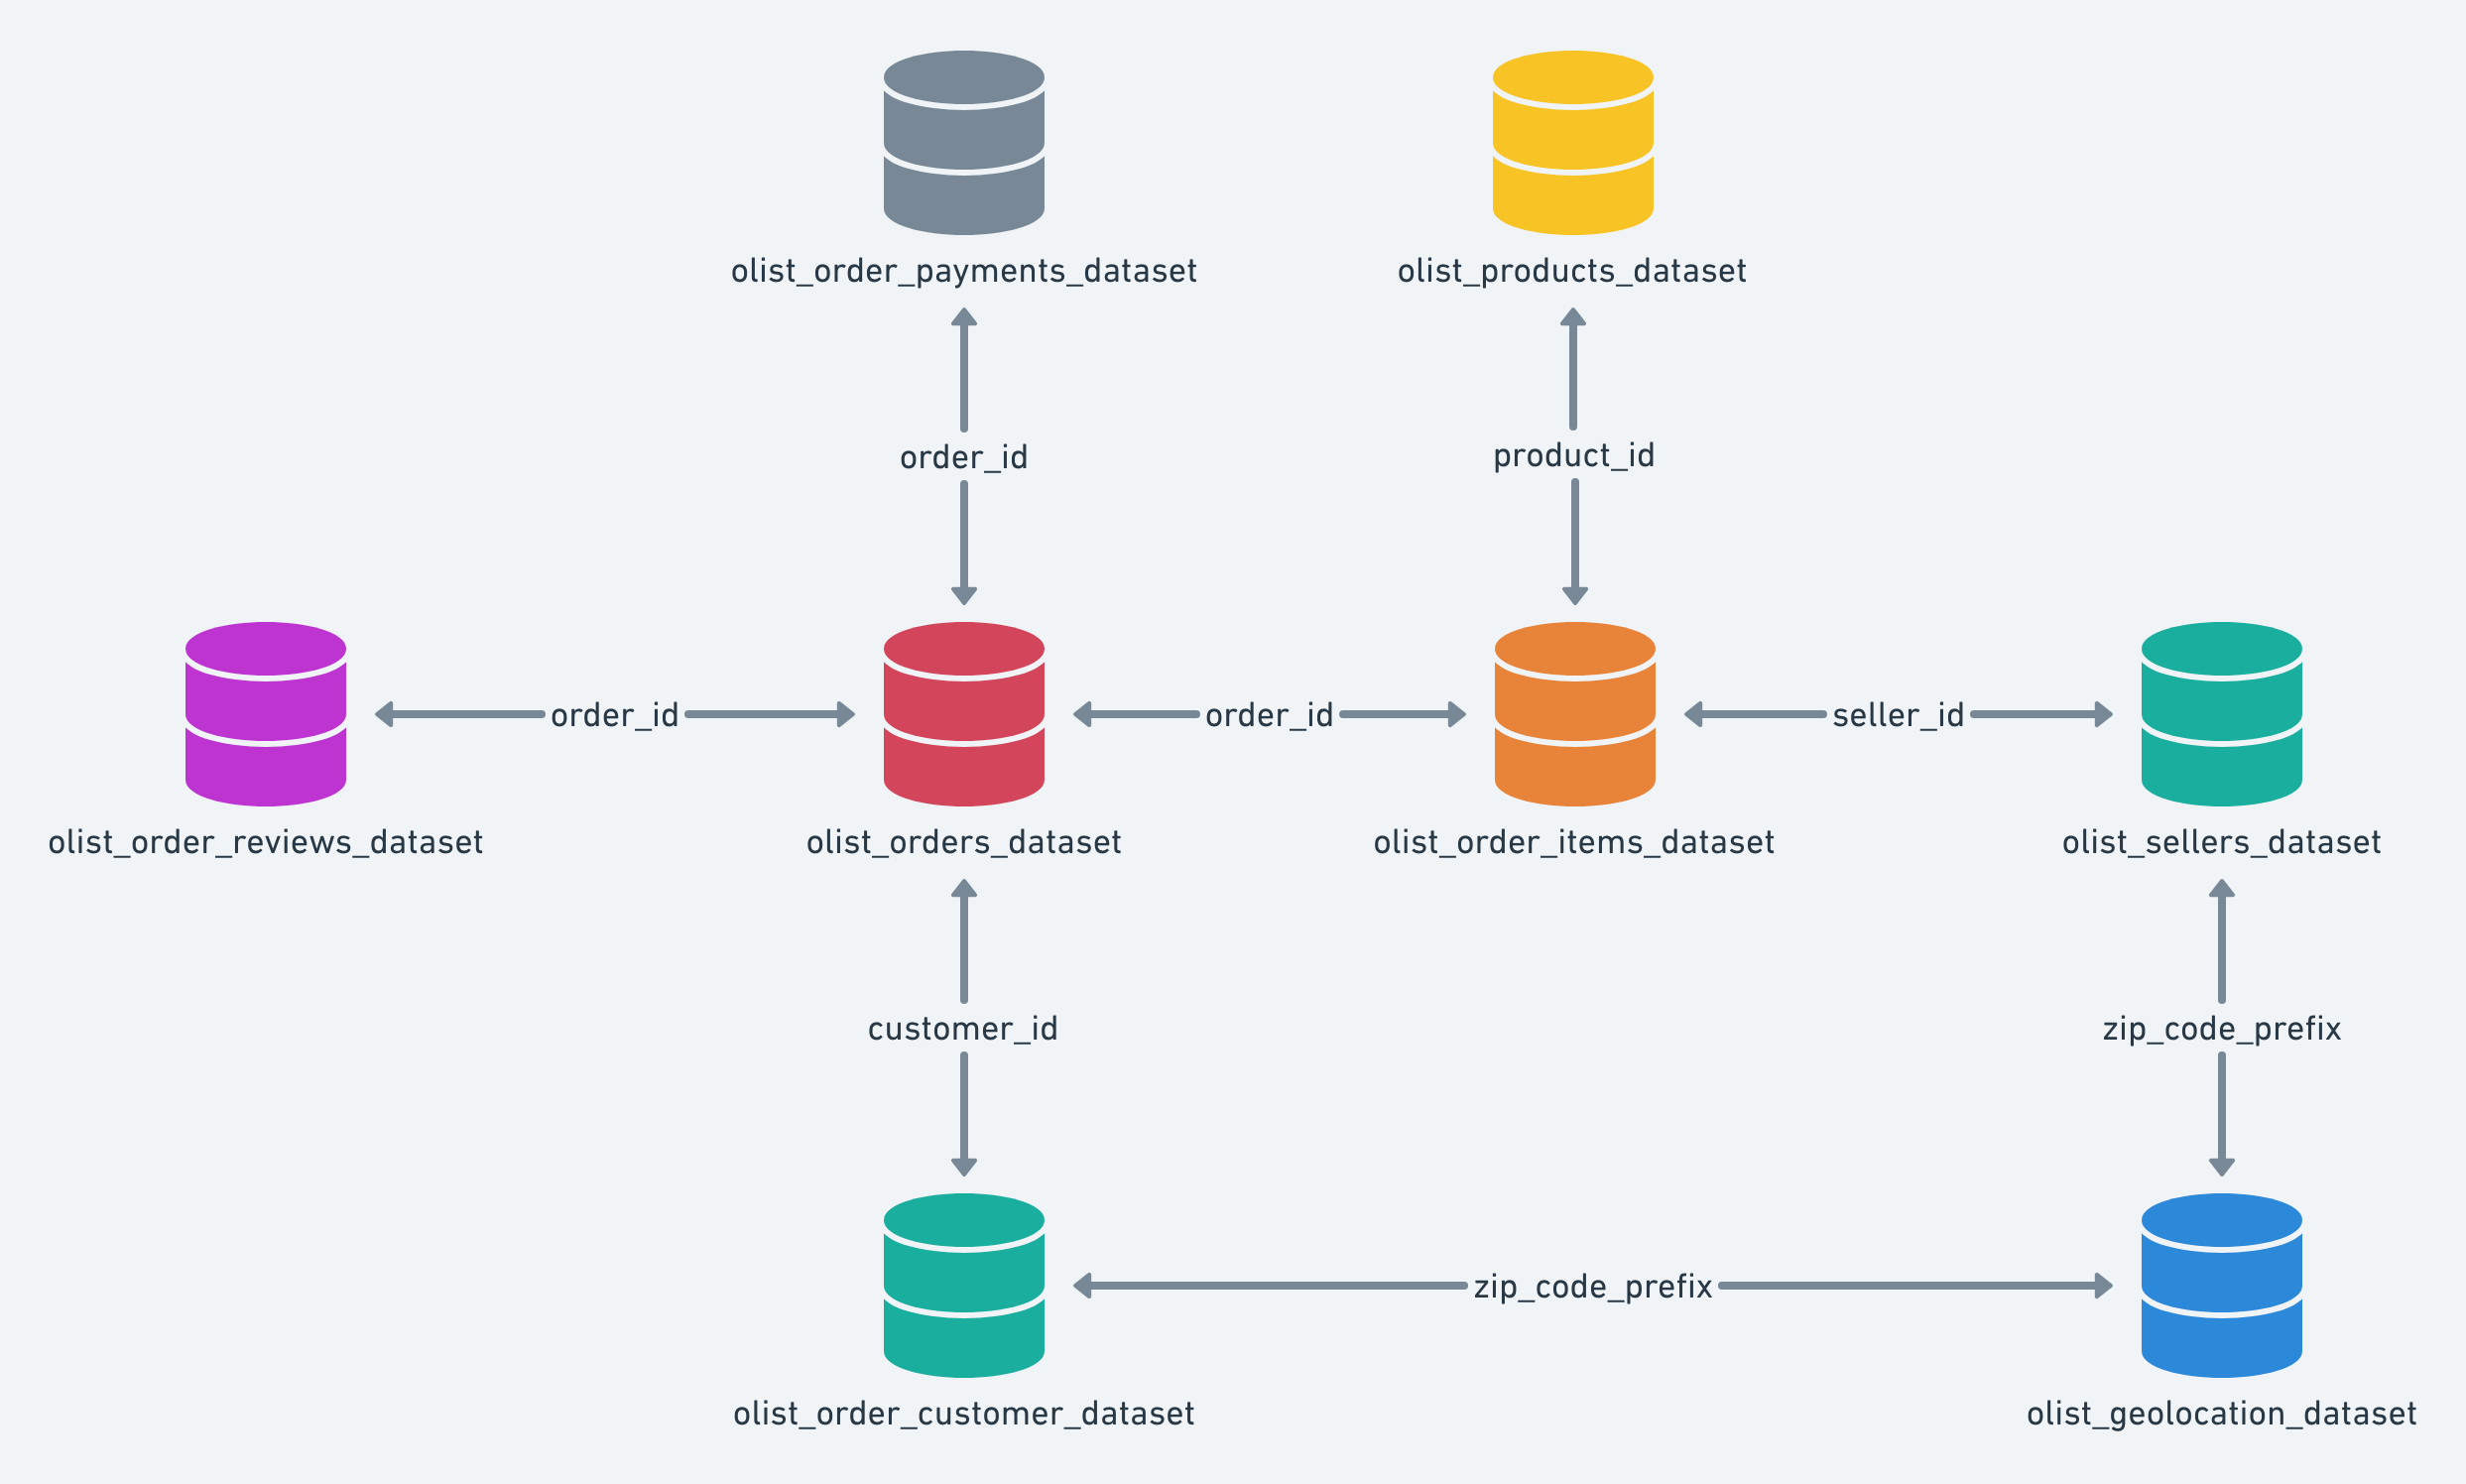

### Dataset Attention

- An order might have multiple items.
- Each item might be fulfilled by a distinct seller.
- All text identifying stores and partners where replaced by the names of Game of Thrones great houses.

## 1. Defining Business Questions
---
1. How has the trend in e-commerce sales changed over the past 2 years?
2. What are the factors influencing sales in Brazil?
3. Is there a correlation between product ratings and the number of reviews with sales volume? Do products with high ratings and positive reviews tend to have higher sales?
4. How is the distribution of sales among various product categories? Are there categories that dominate sales, and are there trends in the changing popularity of categories over time?
5. Is there a correlation between buyer location and sales? How does shipping cost influence purchasing decisions? Are there specific regions more inclined to make purchases?
6. What is the customer behavior in terms of purchase frequency and retention?
7. Which products are most commonly purchased in Brazil?
8. What is the average order value in Brazil?
9. How long does it take for goods to be delivered in Brazil?

## 2. Import Libraries
---
import libraries that we need for data analysis and visualization.

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Helper Function

In [44]:
def data_overview(df, corr=False, label_name=None, sort_by='qtd_null', thresh_percent_null=0, thresh_corr_label=0):
    """
    Steps:
        1. Identify attributes with missing values in the set
        2. Analyze the primitive type of each attribute
        3. Analyze the number of entries in case of categorical attributes
        4. Extract the Pearson correlation with the target for each attribute
        5. Apply rules defined in the arguments
        6. Return the created overview dataset

    Arguments:
        df -- DataFrame to be analyzed [pandas.DataFrame]
        label_name -- name of the target variable [string]
        sort_by -- column to sort the overview dataset [string - default: 'qtd_null']
        thresh_percent_null -- filter for missing values [int - default: 0]
        threh_corr_label -- filter for correlation with the target [int - default: 0]

    Return
        df_overview -- consolidated dataset containing column analysis [pandas.DataFrame]
    """
    
    # Create DataFrame with information about missing values
    df_null = pd.DataFrame(df.isnull().sum()).reset_index()
    df_null.columns = ['feature', 'qtd_null']
    df_null['percent_null'] = df_null['qtd_null'] / len(df)

    # Return primitive type and qtd of entries for categorical
    df_null['dtype'] = df_null['feature'].apply(lambda x: df[x].dtype)
    df_null['qtd_cat'] = [len(df[col].value_counts()) if df[col].dtype == 'object' else 0 for col in
                          df_null['feature'].values]

    if corr:
        # Extract correlation information with the target
        label_corr = pd.DataFrame(df.corr()[label_name])
        label_corr = label_corr.reset_index()
        label_corr.columns = ['feature', 'target_pearson_corr']

        # Merge information
        df_null_overview = df_null.merge(label_corr, how='left', on='feature')
        df_null_overview.query('target_pearson_corr > @thresh_corr_label')
    else:
        df_null_overview = df_null

    # Filter missing values according to thresholds
    df_null_overview.query('percent_null > @thresh_percent_null')

    # Sort DataFrame
    df_null_overview = df_null_overview.sort_values(by=sort_by, ascending=False)
    df_null_overview = df_null_overview.reset_index(drop=True)

    return df_null_overview

In [45]:
def format_spines(ax, right_border=True):
    """
    This function sets up borders from an axis and personalize colors

    Input:
        Axis and a flag for deciding or not to plot the right border
    Returns:
        Plot configuration
    """
    # Setting up colors
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

In [46]:
def single_countplot(df, ax, x=None, y=None, top=None, order=True, hue=False, palette='plasma',
                     width=0.75, sub_width=0.3, sub_size=12):
    """
    Parameters
    ----------
    df: DataFrame containing the data for plotting.
    ax: The axes object where the countplot will be drawn.
    x: The variable to be plotted on the x-axis (optional).
    y: The variable to be plotted on the y-axis (optional).
    top: Number of top categories to display in the plot (optional).
    order: Whether to sort categories by frequency (default is True).
    hue: Variable to divide the data and use different colors to represent the divisions (optional).
    palette: Color palette to be used for the plot (default is 'plasma').
    width: Width of the bars in the countplot (default is 0.75).
    sub_width: Width of sub-plots (if used, default is 0.3).
    sub_size: Font size for sub-plots (if used, default is 12).

    Returns
    -------
    None
    """

    # Checking for plotting by breaking down a categorical variable
    ncount = len(df)
    if x:
        col = x
    else:
        col = y

    # Checking for plotting the top categories
    if top is not None:
        cat_count = df[col].value_counts()
        top_categories = cat_count[:top].index
        df = df[df[col].isin(top_categories)]

    # Validating other arguments and plotting the graph
    if hue != False:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index, hue=hue)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, hue=hue)
    else:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax)

    # Formatting axes
    format_spines(ax, right_border=False)

    # Adding percentage labels
    if x:
        for p in ax.patches:
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), ha='center', va='bottom')
    else:
        for p in ax.patches:
            x = p.get_bbox().get_points()[1, 0]
            y = p.get_bbox().get_points()[:, 1]
            ax.annotate('{} ({:.1f}%)'.format(int(x), 100. * x / ncount), (x, y.mean()), va='center')


## 3. Data Wrangling
------
Data wrangling is the process of cleaning, transforming, and organizing raw and unstructured data into a structured format suitable for analysis. It involves tasks like removing inconsistencies, handling missing values, and converting data into a usable and coherent form for further data analysis and modeling.

### 3.1. Gathering Data
There is a table with .csv format in this dataset, namely hour.csv. the data is then loaded using the pandas library

In [47]:
df_item = pd.read_csv("order_items_dataset.csv")
df_reviews = pd.read_csv("order_reviews_dataset.csv")
df_orders = pd.read_csv("orders_dataset.csv")
df_products = pd.read_csv("products_dataset.csv")
df_geolocation = pd.read_csv("geolocation_dataset.csv")
df_sellers = pd.read_csv("sellers_dataset.csv")
df_order_pay = pd.read_csv("order_payments_dataset.csv")
df_customers = pd.read_csv("customers_dataset.csv")
df_category = pd.read_csv("product_category_name_translation.csv")

### 3.2 Assessing Data
At this step, the quality of the data will be considered whether there are any problems with the dataframes that have been collected.
There are several problems that commonly happen to the data including:
1. missing value
2. duplicate value
3. inconsistant data
4. Invalid value
5. Inaccurate value
6. outlier

In [48]:
datasets = [df_item, df_reviews, df_orders, df_products, df_geolocation,
            df_sellers, df_order_pay, df_customers, df_category]
names = ['df_item', 'df_reviews', 'df_orders', 'df_products', 'df_geolocation',
         'df_sellers', 'df_order_pay', 'df_customers', 'df_category']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['percent_missingcolumns'] = [', '.join([ "{:.1f}".format(100*null/df.shape[0]) + "%" for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns,percent_missingcolumns
0,df_item,112650,7,0,0,,
1,df_reviews,99224,7,145903,2,"review_comment_title, review_comment_message","88.3%, 58.7%"
2,df_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date","0.2%, 1.8%, 3.0%"
3,df_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm","1.9%, 1.9%, 1.9%, 1.9%, 0.0%, 0.0%, 0.0%, 0.0%"
4,df_geolocation,1000163,5,0,0,,
5,df_sellers,3095,4,0,0,,
6,df_order_pay,103886,5,0,0,,
7,df_customers,99441,5,0,0,,
8,df_category,71,2,0,0,,


In [49]:
datasets = [df_item, df_reviews, df_orders, df_products, df_geolocation,
            df_sellers, df_order_pay, df_customers, df_category]
names = ['df_item', 'df_reviews', 'df_orders', 'df_products', 'df_geolocation',
         'df_sellers', 'df_order_pay', 'df_customers', 'df_category']

# Inisialisasi DataFrame df_overview
df_overview = pd.DataFrame({})
name_col = []

# Gunakan pd.concat() untuk menggabungkan DataFrames
for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_overview = pd.concat([df_overview, data_overview(df)], ignore_index=True)
    df_overview['dataset_name'] = name_col
# Pilih kolom yang diperlukan
df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]

# Tampilkan DataFrame
df_overview

,dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
0,df_item,order_id,0,0.000000,object,98666
1,df_item,order_item_id,0,0.000000,int64,0
2,df_item,product_id,0,0.000000,object,32951
3,df_item,seller_id,0,0.000000,object,3095
4,df_item,shipping_limit_date,0,0.000000,object,93318
5,df_item,price,0,0.000000,float64,0
6,df_item,freight_value,0,0.000000,float64,0
7,df_reviews,review_comment_title,87656,0.883415,object,4527
8,df_reviews,review_comment_message,58247,0.587025,object,36159
9,df_reviews,review_id,0,0.000000,object,98410


As we can see, there are missing values. Thus, we will remove the rows which have missing values using the dropna() function from the Pandas library that have less than 20% missing values and drop columns that have more than 50% missing values. 

From the summary table, the table whose columns have missing values is:
- df_orders
- df_products

and the table that whose columns will be dropped is:
- df_reviews

### 3.3. Cleaning Data
From the problems that have been obtained in stage 3.2, this stage will try to clean up the problems that have been identified.

In [50]:
df_orders = df_orders.dropna()
df_products = df_products.dropna()
df_customers = df_customers.dropna()

In [51]:
df_reviews = df_reviews.drop(columns=['review_comment_title', 'review_comment_message'])

In [52]:
datasets = [df_item, df_reviews, df_orders, df_products, df_geolocation,
            df_sellers, df_order_pay, df_customers, df_category]
names = ['df_item', 'df_reviews', 'df_orders', 'df_products', 'df_geolocation',
         'df_sellers', 'df_order_pay', 'df_customers', 'df_category']
for dataset in datasets:
    dataset = dataset.drop_duplicates()

In [53]:
# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['percent_missingcolumns'] = [', '.join([ "{:.1f}".format(100*null/df.shape[0]) + "%" for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns,percent_missingcolumns
0,df_item,112650,7,0,0,,
1,df_reviews,99224,5,0,0,,
2,df_orders,96461,8,0,0,,
3,df_products,32340,9,0,0,,
4,df_geolocation,1000163,5,0,0,,
5,df_sellers,3095,4,0,0,,
6,df_order_pay,103886,5,0,0,,
7,df_customers,99441,5,0,0,,
8,df_category,71,2,0,0,,


In [54]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [56]:
#Save the merged table
datasets = [df_item, df_reviews, df_orders, df_products, df_geolocation,
            df_sellers, df_order_pay, df_customers, df_category]
names = ['df_item', 'df_reviews', 'df_orders', 'df_products', 'df_geolocation',
         'df_sellers', 'df_order_pay', 'df_customers', 'df_category']
for name, df in zip(names, datasets):
    df.to_csv("cleaned_"+name+ ".csv",
          header=True
         , index=False)

### Showing the result of the table after Cleaning data

In [13]:
# merging the datasets
df_main = pd.merge(df_orders,df_order_pay, on='order_id', how='inner')
df_main = df_main.merge(df_reviews, on='order_id', how='inner')
df_main = df_main.merge(df_customers, on='customer_id', how='inner')
df_main = df_main.merge(df_item, on='order_id', how='inner')
df_main = df_main.merge(df_products, on='product_id', how='inner')
df_main = df_main.merge(df_sellers, on='seller_id', how='inner')
df_main = df_main.merge(df_geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')

In [14]:
# Convert all float64 columns to float32
float64_columns = df_main.select_dtypes(include='float64').columns
df_main[float64_columns] = df_main[float64_columns].astype('float16')

# Convert all int64 columns to int32
int64_columns = df_main.select_dtypes(include='int64').columns
df_main[int64_columns] = df_main[int64_columns].astype('int16')

In [15]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17315215 entries, 0 to 17315214
Data columns (total 42 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   order_id                       object 
 1   customer_id                    object 
 2   order_status                   object 
 3   order_purchase_timestamp       object 
 4   order_approved_at              object 
 5   order_delivered_carrier_date   object 
 6   order_delivered_customer_date  object 
 7   order_estimated_delivery_date  object 
 8   payment_sequential             int16  
 9   payment_type                   object 
 10  payment_installments           int16  
 11  payment_value                  float16
 12  review_id                      object 
 13  review_score                   int16  
 14  review_creation_date           object 
 15  review_answer_timestamp        object 
 16  customer_unique_id             object 
 17  customer_zip_code_prefix       int16  
 18  

In [16]:
# df_main.head()

In [17]:
dropped_columns = ['order_id', 'product_description_lenght', 'product_photos_qty', 'product_length_cm', 'product_height_cm', 'product_width_cm']

In [18]:
df_main= df_main.drop(dropped_columns, axis=1)

### Saving The Modified Dataset

In [19]:
# #Save the merged table
# df_main.to_csv("cleaned_Merged_ECommerce_Dataset.csv",
#           header=True
#          , index=False
#          , chunksize=100000
#          , compression='gzip'
#          , encoding='utf-8')

## 5. Visualization and Answer
---


###  Trend in E-Commerce Sales Changed

In [20]:
df_orders_customer = df_orders.merge(df_customers, how='left', on='customer_id').copy()
df_orders_customer.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


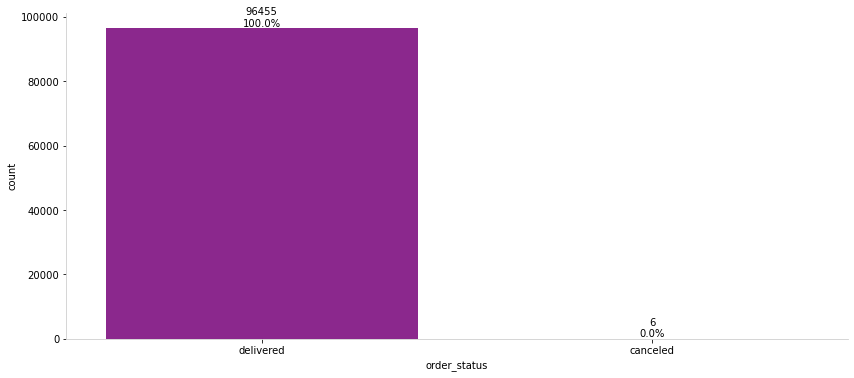

In [21]:
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='order_status', ax=ax)
plt.show()

In [22]:
orderstatuslist = df_orders['order_status'].value_counts().tolist()

In [23]:
orderstatuslist

[96455, 6]

In [24]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders_customer[col] = pd.to_datetime(df_orders[col])

In [25]:
df_orders_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96461 entries, 0 to 96460
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       93573 non-null  datetime64[ns]
 4   order_approved_at              93573 non-null  datetime64[ns]
 5   order_delivered_carrier_date   93573 non-null  datetime64[ns]
 6   order_delivered_customer_date  93573 non-null  datetime64[ns]
 7   order_estimated_delivery_date  93573 non-null  datetime64[ns]
 8   customer_unique_id             96461 non-null  object        
 9   customer_zip_code_prefix       96461 non-null  int64         
 10  customer_city                  96461 non-null  object        
 11  customer_state 

In [26]:
df_orders_customer.sort_values(by='order_purchase_timestamp', ascending = False, inplace = True) 

In [27]:
df_orders_customer = df_orders_customer.dropna()
df_orders_customer.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
88097,2b1744114b2335cc79c6c45cd8af7290,acd9e8ca124f434045dce23b783e7540,delivered,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-08-29 16:57:00,2018-08-30 16:23:36,2018-09-05,de57975e2ff2cd2d0570b9ae3e8a4de6,15110,guapiacu,SP
69678,b552bf4c093b6c4804fa08eaee94a786,e346b26187c9fd7380d7cb6b11a0581e,delivered,2018-08-29 14:52:00,2018-08-29 15:05:22,2018-08-29 20:01:00,2018-08-30 16:36:59,2018-09-03,a3e9df44f0c518263a1513f7a03b2a0d,40387,salvador,BA
31486,a4fcc7fbe8b6b02b25175965c44780ef,24f35142319f5e6de65cf5cd4220dfcc,delivered,2018-08-29 14:18:28,2018-08-29 14:30:23,2018-08-29 18:51:00,2018-08-30 16:52:31,2018-09-11,19ca668a73743cde5a961ca9987b83ae,83327,pinhais,PR
30077,4dac0c9aec5f460f203ce439f8af0f8c,72b368a9206b6e158934fdc1b79f962c,delivered,2018-08-29 14:18:23,2018-08-29 14:31:07,2018-08-29 15:29:00,2018-08-30 16:24:55,2018-09-04,35d68a3cffde6623481e49668e51ae08,92120,canoas,RS
67826,9bf1ceb820bc945c03785708af99d14a,2cf9e0cdf87e31f8f72fdf33448e3453,delivered,2018-08-29 11:06:11,2018-08-29 11:24:02,2018-08-29 17:46:00,2018-08-30 23:56:54,2018-09-04,ac541f60932b50a24e98fd4088c4d4df,71735,brasilia,DF


In [28]:
# Extracting attributes for purchase date - Year and Month
df_orders_customer['order_purchase_year'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders_customer['order_purchase_month'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders_customer['order_purchase_month_name'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders_customer['order_purchase_year_month'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders_customer['order_purchase_date'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders_customer['order_purchase_day'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders_customer['order_purchase_dayofweek'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders_customer['order_purchase_dayofweek_name'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders_customer['order_purchase_hour'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders_customer['order_purchase_time_day'] = pd.cut(df_orders_customer['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders_customer.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
88097,2b1744114b2335cc79c6c45cd8af7290,acd9e8ca124f434045dce23b783e7540,delivered,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-08-29 16:57:00,2018-08-30 16:23:36,2018-09-05,de57975e2ff2cd2d0570b9ae3e8a4de6,15110,...,2018,8,Aug,201808,20180829,29,2,Wed,15,Afternoon
69678,b552bf4c093b6c4804fa08eaee94a786,e346b26187c9fd7380d7cb6b11a0581e,delivered,2018-08-29 14:52:00,2018-08-29 15:05:22,2018-08-29 20:01:00,2018-08-30 16:36:59,2018-09-03,a3e9df44f0c518263a1513f7a03b2a0d,40387,...,2018,8,Aug,201808,20180829,29,2,Wed,14,Afternoon
31486,a4fcc7fbe8b6b02b25175965c44780ef,24f35142319f5e6de65cf5cd4220dfcc,delivered,2018-08-29 14:18:28,2018-08-29 14:30:23,2018-08-29 18:51:00,2018-08-30 16:52:31,2018-09-11,19ca668a73743cde5a961ca9987b83ae,83327,...,2018,8,Aug,201808,20180829,29,2,Wed,14,Afternoon
30077,4dac0c9aec5f460f203ce439f8af0f8c,72b368a9206b6e158934fdc1b79f962c,delivered,2018-08-29 14:18:23,2018-08-29 14:31:07,2018-08-29 15:29:00,2018-08-30 16:24:55,2018-09-04,35d68a3cffde6623481e49668e51ae08,92120,...,2018,8,Aug,201808,20180829,29,2,Wed,14,Afternoon
67826,9bf1ceb820bc945c03785708af99d14a,2cf9e0cdf87e31f8f72fdf33448e3453,delivered,2018-08-29 11:06:11,2018-08-29 11:24:02,2018-08-29 17:46:00,2018-08-30 23:56:54,2018-09-04,ac541f60932b50a24e98fd4088c4d4df,71735,...,2018,8,Aug,201808,20180829,29,2,Wed,11,Morning


C:\Users\Reinaldo\AppData\Local\Temp\ipykernel_26796\1553480407.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


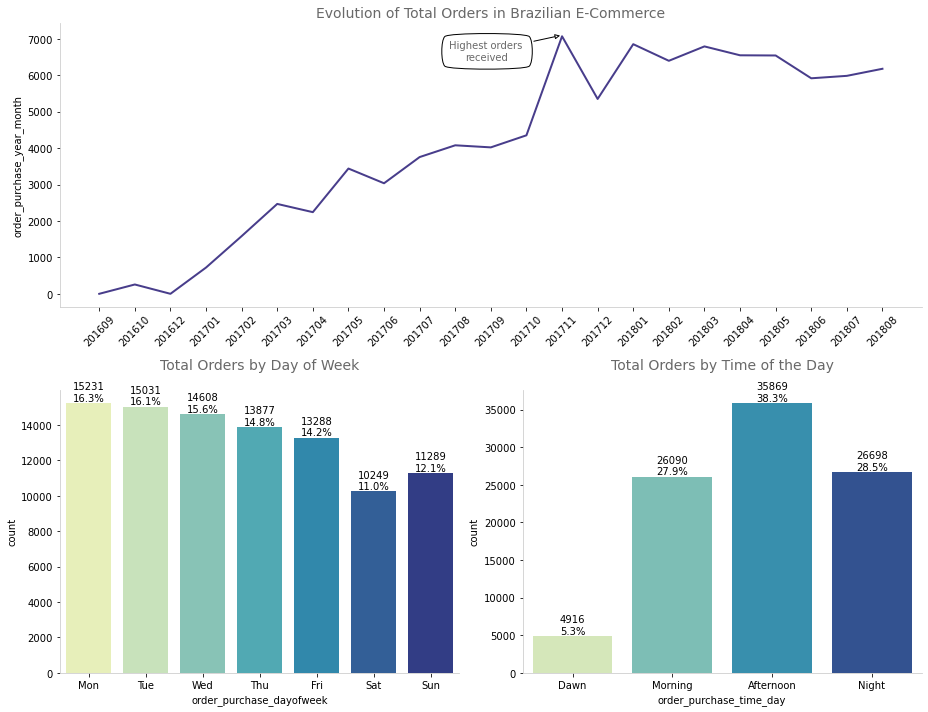

In [29]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders_customer['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7100), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(df_orders_customer, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders_customer, x='order_purchase_time_day', ax=ax3, order=False, palette='YlGnBu')
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

In [30]:
# #Save the merged table
# df_orders_customer.to_csv("cleaned_Merged_df_orders_customer.csv",
#           header=True
#          , index=False
#          , chunksize=100000
#          , compression='gzip'
#          , encoding='utf-8')

**Insight**
1. E-commerce on Brazil really has a growing trend along the time. We can see some seasonality with peaks at specific months, but in general we can see clear that customers are more prone to buy things online than before.
2. Monday are the prefered day for brazilian's customers and they tend to buy more at afternoons.

### Geographic based on Zip Codes

In [58]:
df_geolocation_copy = df_geolocation.copy()
df_geolocation_copy = df_geolocation_copy.astype(str)

In [60]:
df_geolocation_copy.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [61]:
df_geolocation_copy['geolocation_zip_code_prefix_1_digits'] = df_geolocation_copy['geolocation_zip_code_prefix'].str[0:1]
df_geolocation_copy['geolocation_zip_code_prefix_2_digits'] = df_geolocation_copy['geolocation_zip_code_prefix'].str[0:2]
df_geolocation_copy['geolocation_zip_code_prefix_3_digits'] = df_geolocation_copy['geolocation_zip_code_prefix'].str[0:3]
df_geolocation_copy['geolocation_zip_code_prefix_4_digits'] = df_geolocation_copy['geolocation_zip_code_prefix'].str[0:4]
df_geolocation_copy.head(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_zip_code_prefix_1_digits,geolocation_zip_code_prefix_2_digits,geolocation_zip_code_prefix_3_digits,geolocation_zip_code_prefix_4_digits
0,1037,-23.545621,-46.639292,sao paulo,SP,1,10,103,1037
1,1046,-23.546081,-46.644820,sao paulo,SP,1,10,104,1046
2,1046,-23.546129,-46.642951,sao paulo,SP,1,10,104,1046


In [62]:
# using dictionary to convert specific columns
convert_dict = {'geolocation_lat': float,
                'geolocation_lng': float
                }
 
df_geolocation_copy = df_geolocation_copy.astype(convert_dict)

In [63]:
# Removing some outliers
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
df_geolocation_copy = df_geolocation_copy[df_geolocation_copy.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
df_geolocation_copy = df_geolocation_copy[df_geolocation_copy.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
df_geolocation_copy = df_geolocation_copy[df_geolocation_copy.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
df_geolocation_copy = df_geolocation_copy[df_geolocation_copy.geolocation_lng <=  -34.79314722]

In [64]:
from datashader.utils import lnglat_to_meters as webm
x, y = webm(df_geolocation_copy.geolocation_lng, df_geolocation_copy.geolocation_lat)
df_geolocation_copy['x'] = pd.Series(x)
df_geolocation_copy['y'] = pd.Series(y)

In [65]:
# transforming the prefixes to int for plotting purposes
df_geolocation_copy['geolocation_zip_code_prefix'] = df_geolocation_copy['geolocation_zip_code_prefix'].astype(int)
df_geolocation_copy['geolocation_zip_code_prefix_1_digits'] = df_geolocation_copy['geolocation_zip_code_prefix_1_digits'].astype(int)
df_geolocation_copy['geolocation_zip_code_prefix_2_digits'] = df_geolocation_copy['geolocation_zip_code_prefix_2_digits'].astype(int)
df_geolocation_copy['geolocation_zip_code_prefix_3_digits'] = df_geolocation_copy['geolocation_zip_code_prefix_3_digits'].astype(int)
df_geolocation_copy['geolocation_zip_code_prefix_4_digits'] = df_geolocation_copy['geolocation_zip_code_prefix_4_digits'].astype(int)

In [66]:
position_map = df_geolocation_copy
agg_name = 'geolocation_zip_code_prefix'
position_map[agg_name].describe().to_frame()

,geolocation_zip_code_prefix
count,1.000121e+06
mean,3.657332e+04
std,3.054939e+04
min,1.001000e+03
25%,1.107500e+04
50%,2.653000e+04
75%,6.350400e+04
max,9.999000e+04


In [67]:
position_map.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_zip_code_prefix_1_digits,geolocation_zip_code_prefix_2_digits,geolocation_zip_code_prefix_3_digits,geolocation_zip_code_prefix_4_digits,x,y
0,1037,-23.545621,-46.639292,sao paulo,SP,1,10,103,1037,-5.191862e+06,-2.698137e+06
1,1046,-23.546081,-46.644820,sao paulo,SP,1,10,104,1046,-5.192478e+06,-2.698193e+06
2,1046,-23.546129,-46.642951,sao paulo,SP,1,10,104,1046,-5.192270e+06,-2.698199e+06
3,1041,-23.544392,-46.639499,sao paulo,SP,1,10,104,1041,-5.191885e+06,-2.697988e+06
4,1035,-23.541578,-46.641607,sao paulo,SP,1,10,103,1035,-5.192120e+06,-2.697646e+06


Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
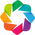

In [68]:
# plot wtih holoviews + datashader - bokeh with map background
import holoviews as hv
import geoviews as gv
import datashader as ds
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr
from datashader.colors import colormap_select, Greys9
from holoviews.streams import RangeXY
from holoviews.operation.datashader import datashade, dynspread, rasterize
from bokeh.io import push_notebook, show, output_notebook
output_notebook()
hv.extension('bokeh')

%opts Overlay [width=800 height=600 toolbar='above' xaxis=None yaxis=None]
%opts QuadMesh [tools=['hover'] colorbar=True] (alpha=0 hover_alpha=0.2)

T = 0.05
PX = 1



In [69]:
def plot_map(data, label, agg_data, agg_name, cmap):
    url="http://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{Z}/{Y}/{X}.png"
    geomap = gv.WMTS(url)
    points = hv.Points(gv.Dataset(data, kdims=['x', 'y'], vdims=[agg_name]))
    agg = datashade(points, element_type=gv.Image, aggregator=agg_data, cmap=cmap)
    zip_codes = dynspread(agg, threshold=T, max_px=PX)
    hover = hv.util.Dynamic(rasterize(points, aggregator=agg_data, width=50, height=25, streams=[RangeXY]), operation=hv.QuadMesh)
    hover = hover.options(cmap=cmap)
    img = geomap * zip_codes * hover
    img = img.relabel(label)
    return img

In [70]:
plot_map(position_map, 'Zip Codes in Brazil', ds.min(agg_name), agg_name, cmap=rainbow)

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.I      :RGB   [x,y]   (R,G,B,A)
      .QuadMesh.I :QuadMesh   [x,y]   (x_y geolocation_zip_code_prefix)

<Axes: xlabel='geolocation_state', ylabel='count'>

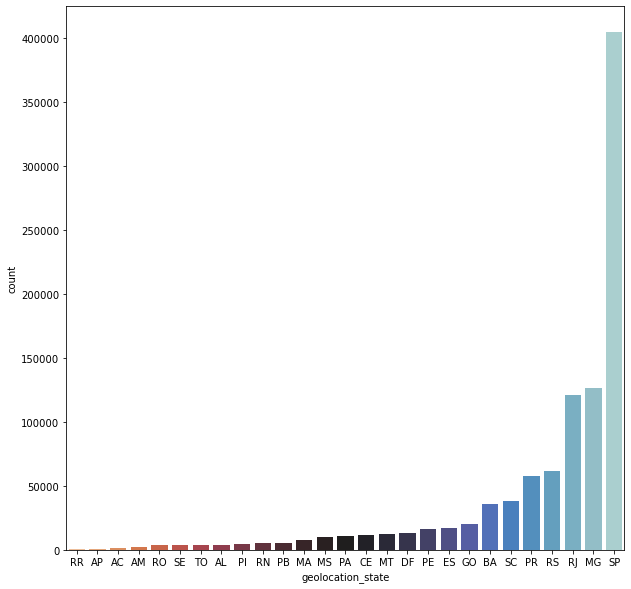

In [71]:
plt.figure(figsize=(10,10))
sns.countplot(x ='geolocation_state', data=df_geolocation_copy, 
              order=df_geolocation_copy['geolocation_state'].value_counts().sort_values().index, 
              palette='icefire_r')

In [72]:
#Save the merged table
df_geolocation_copy.to_csv("cleaned_Merged_df_geolocation.csv",
          header=True
         , index=False
         , chunksize=100000
         , compression='gzip'
         , encoding='utf-8')

**Insight**
1. The above chart shows very obvious different pattern on how casual and registered bikeshare rides differs based on hour in a day.
2. The registered bikeshare rides shows peak on 8.00 and 17.00. Given both these hours are time when people go to work and coming back from work, it's possible that registered bikeshare users use the bike to commute to work.
3. On the other hand, casual bikeshare rides shows higher frequency  during the day, then it starts to decrease after 17.00.

### Factors Influencing Sales in Brazil

Text(0.5, 1.0, 'Correlation Matrix')

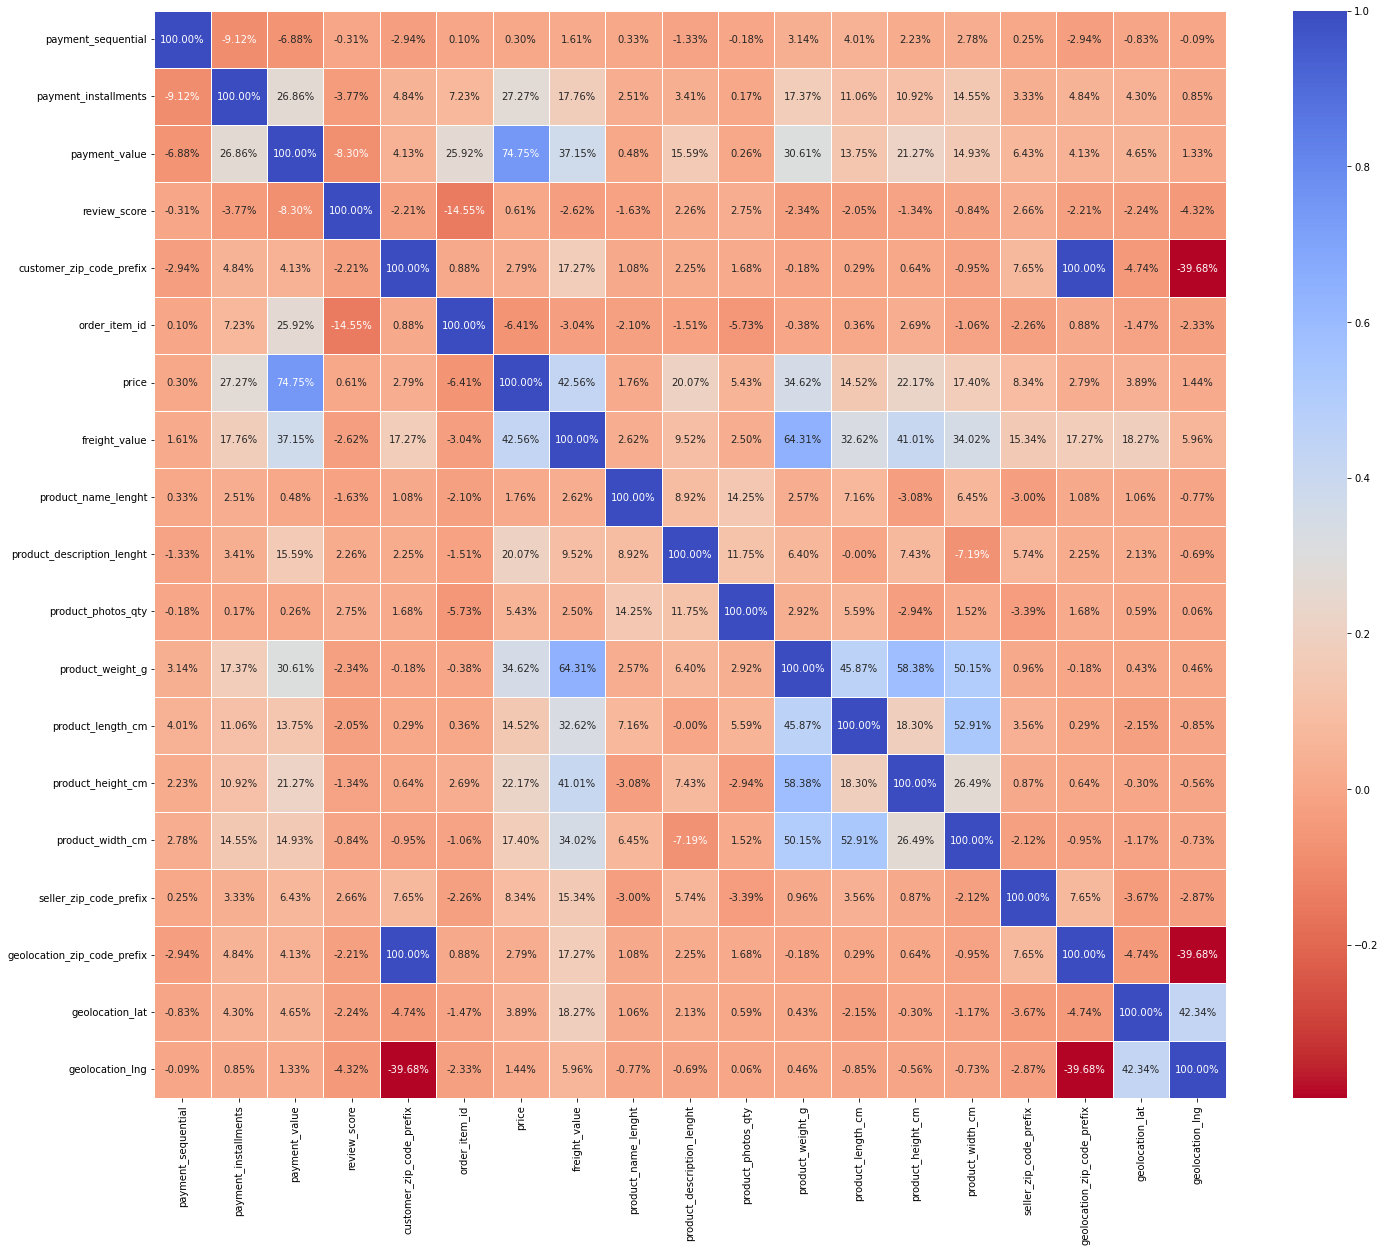

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(24,20))

# Entire DataFrame
corr = df_main.corr()
sns.heatmap(corr, cmap='coolwarm_r',annot=True,  fmt=".2%", annot_kws={'size':10}, ax=ax, linewidth=.5)
ax1.set_title("Correlation Matrix", fontsize=14)

**Insight**
1. The above chart shows very obvious different pattern on how casual and registered bikeshare rides differs based on hour in a day.
2. The registered bikeshare rides shows peak on 8.00 and 17.00. Given both these hours are time when people go to work and coming back from work, it's possible that registered bikeshare users use the bike to commute to work.
3. On the other hand, casual bikeshare rides shows higher frequency  during the day, then it starts to decrease after 17.00.

### Customer Behavior in Terms of Purchase

In [77]:
df_reviews_copy = df_reviews.copy()

In [78]:
df_reviews_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_creation_date     99224 non-null  object
 4   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [79]:
df_reviews_copy.head()

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,2018-03-01 00:00:00,2018-03-02 10:26:53


In [80]:
# Changing the data type for date columns
timestamp_cols = ['review_creation_date', 'review_answer_timestamp']
for col in timestamp_cols:
    df_reviews_copy[col] = pd.to_datetime(df_reviews[col])

In [81]:
df_reviews_copy['review_answer_timestamp'] = pd.to_datetime(df_reviews_copy["review_answer_timestamp"]).dt.date

Text(0, 0.5, 'No. of Reviews')

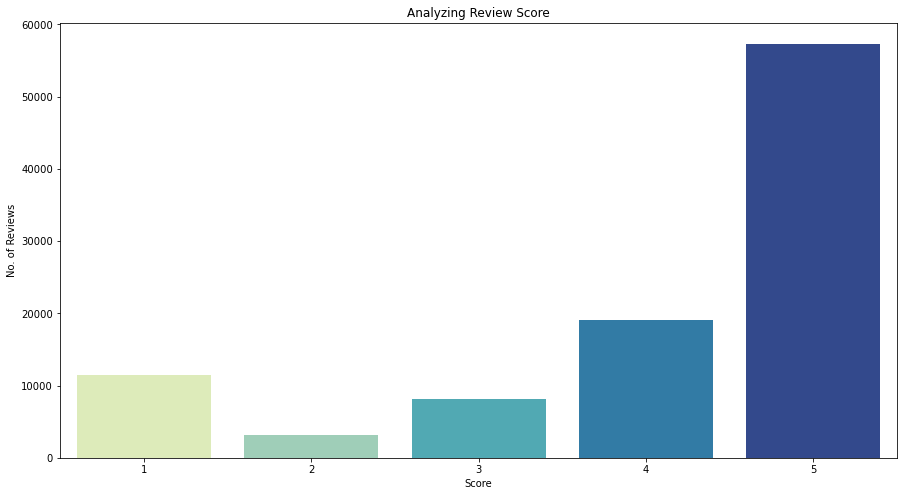

In [82]:
# analyzing the review score
plt.figure(figsize=(15,8))
sns.countplot(x='review_score', data=df_reviews_copy, palette='YlGnBu')
plt.title('Analyzing Review Score')
plt.xlabel('Score')
plt.ylabel('No. of Reviews')

In [83]:
#Save the merged table
df_reviews_copy.to_csv("cleaned_Merged_df_reviews_copy.csv",
          header=True
         , index=False
         , chunksize=100000
         , compression='gzip'
         , encoding='utf-8')

In [84]:
df_order_pay_copy = df_order_pay.copy()

Text(0.5, 1.0, 'Top 10 Products')

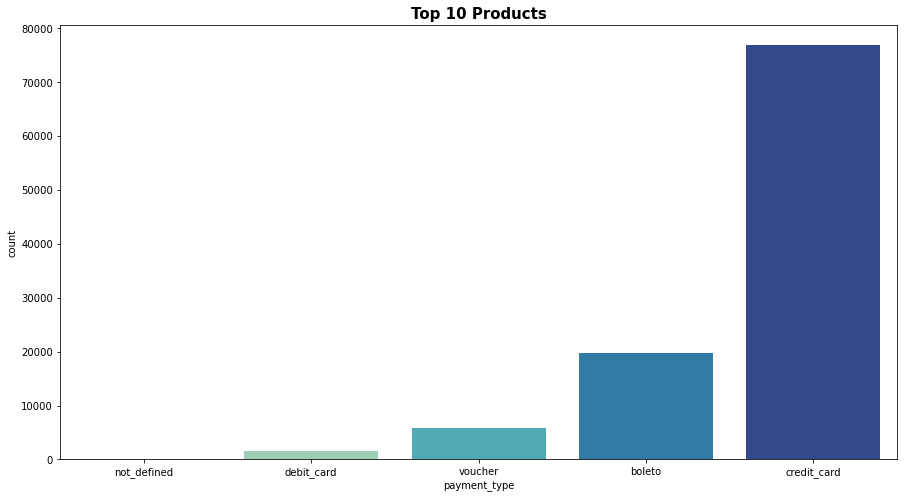

In [85]:
# analyzing the payment methods chosen by different customers
plt.figure(figsize=(15,8))
sns.countplot(x='payment_type', data=df_order_pay_copy, palette='YlGnBu',
             order=df_order_pay_copy['payment_type'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')

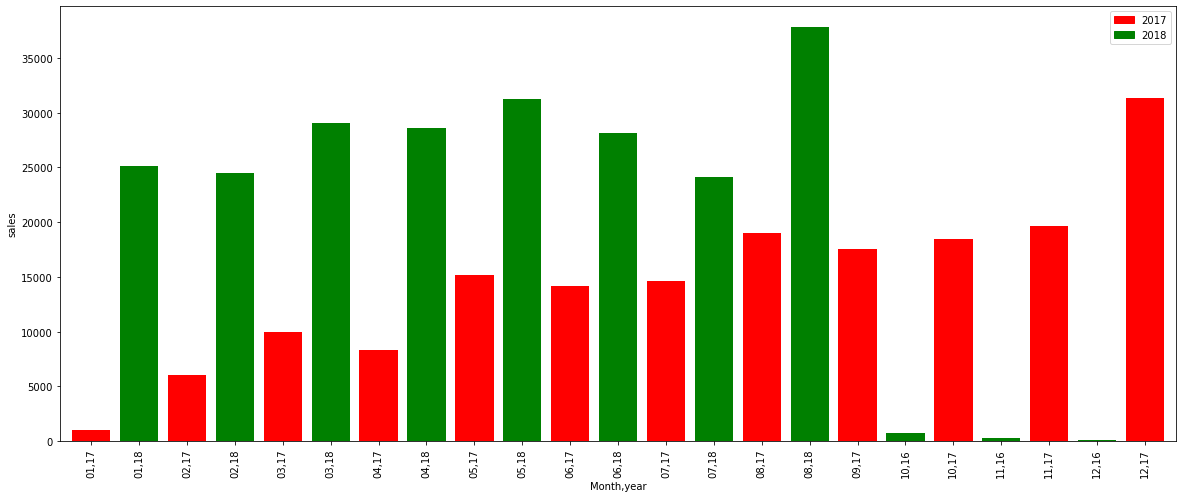

In [86]:
#understanding the growth of Olist as an ecommerce company from the range of data given to us
import matplotlib.patches as mpatches
monthly_sales_data = df_reviews_copy.groupby(df_reviews_copy['review_creation_date'].dt.strftime('%m,%y'))['review_score'].sum().plot(kind='bar',figsize = (20,8),color=['r','g'],width=0.8)
plt.ylabel('sales')


red_patch = mpatches.Patch(color='red', label='2017')
green_patch = mpatches.Patch(color='green', label='2018')
plt.legend(handles=[red_patch,green_patch])
plt.xlabel('Month,year')
plt.show()

In [87]:
#Save the merged table
df_reviews_copy.to_csv("cleaned_Merged_df_order_pay_copy.csv",
          header=True
         , index=False
         , chunksize=100000
         , compression='gzip'
         , encoding='utf-8')

**Insight**
1. The above chart shows very obvious different pattern on how casual and registered bikeshare rides differs based on hour in a day.
2. The registered bikeshare rides shows peak on 8.00 and 17.00. Given both these hours are time when people go to work and coming back from work, it's possible that registered bikeshare users use the bike to commute to work.
3. On the other hand, casual bikeshare rides shows higher frequency  during the day, then it starts to decrease after 17.00.

### Customer Top 10 Product and Sales among Various Product Categories

In [89]:
#Merge data
total_orders=pd.merge(df_orders, df_item)
df_orders_item_products=pd.merge(total_orders,df_products, on="product_id")
df_orders_item_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108643 entries, 0 to 108642
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       108643 non-null  object 
 1   customer_id                    108643 non-null  object 
 2   order_status                   108643 non-null  object 
 3   order_purchase_timestamp       108643 non-null  object 
 4   order_approved_at              108643 non-null  object 
 5   order_delivered_carrier_date   108643 non-null  object 
 6   order_delivered_customer_date  108643 non-null  object 
 7   order_estimated_delivery_date  108643 non-null  object 
 8   order_item_id                  108643 non-null  int64  
 9   product_id                     108643 non-null  object 
 10  seller_id                      108643 non-null  object 
 11  shipping_limit_date            108643 non-null  object 
 12  price                         

In [90]:
df_orders_item_products['product_id_shorten']=df_orders_item_products['product_id'].str[-8:]

Text(0.5, 1.0, 'Top 10 Products')

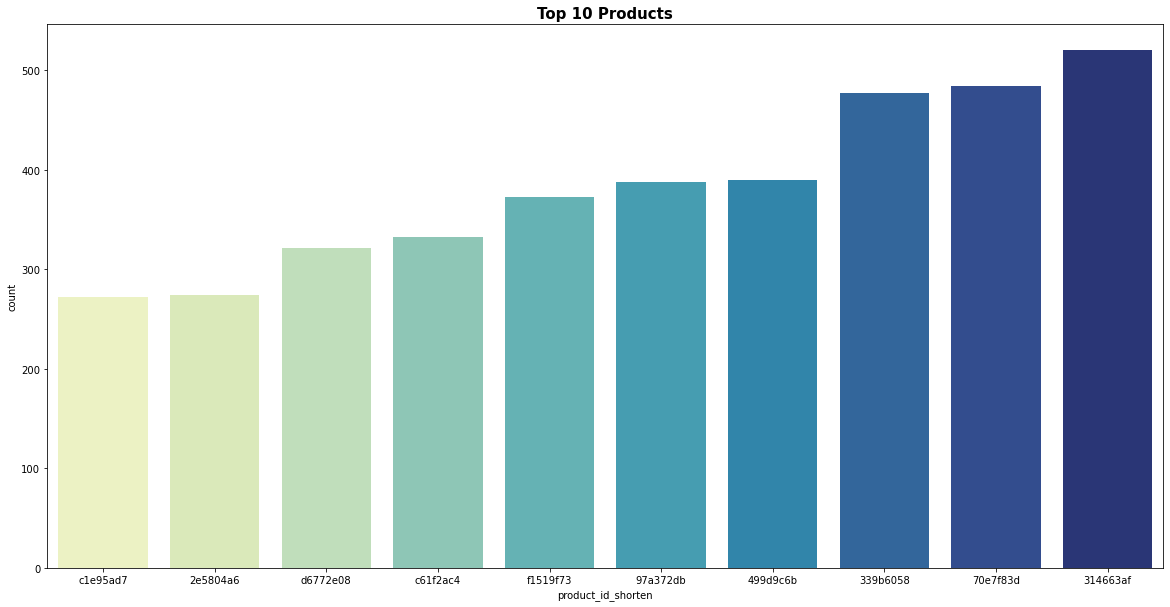

In [91]:
#Plotting Top 10 Products
plt.figure(figsize=(20,10))
sns.countplot(x='product_id_shorten', data=df_orders_item_products, palette='YlGnBu',
             order=df_orders_item_products['product_id_shorten'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')

In [93]:
#Save the merged table
df_orders_item_products.to_csv("cleaned_Merged_df_orders_item_products.csv",
          header=True
         , index=False
         , chunksize=100000
         , compression='gzip'
         , encoding='utf-8')

In [94]:
# merging the product and prodinfo tables
df_products_copy = df_products.merge(df_category, left_on='product_category_name', right_on='product_category_name_english').copy()

In [95]:
df_products_copy.head()

,product_id,product_category_name_x,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_y,product_category_name_english
0,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.0,1272.0,4.0,18350.0,70.0,24.0,44.0,cool_stuff,cool_stuff
1,7a8dac4aaa16bc642e4df33adcf03303,cool_stuff,38.0,1701.0,2.0,11750.0,18.0,40.0,79.0,cool_stuff,cool_stuff
2,5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,38.0,1176.0,3.0,15350.0,47.0,40.0,47.0,cool_stuff,cool_stuff
3,b5cfb1d3c5e435a7a52227e08f220ee7,cool_stuff,55.0,410.0,2.0,1300.0,36.0,16.0,24.0,cool_stuff,cool_stuff
4,fdeb34a9f03fea7c3937dd62d1d0287e,cool_stuff,58.0,1252.0,1.0,1100.0,30.0,20.0,23.0,cool_stuff,cool_stuff


Text(0.5, 1.0, 'Category Wise Product Distribution')

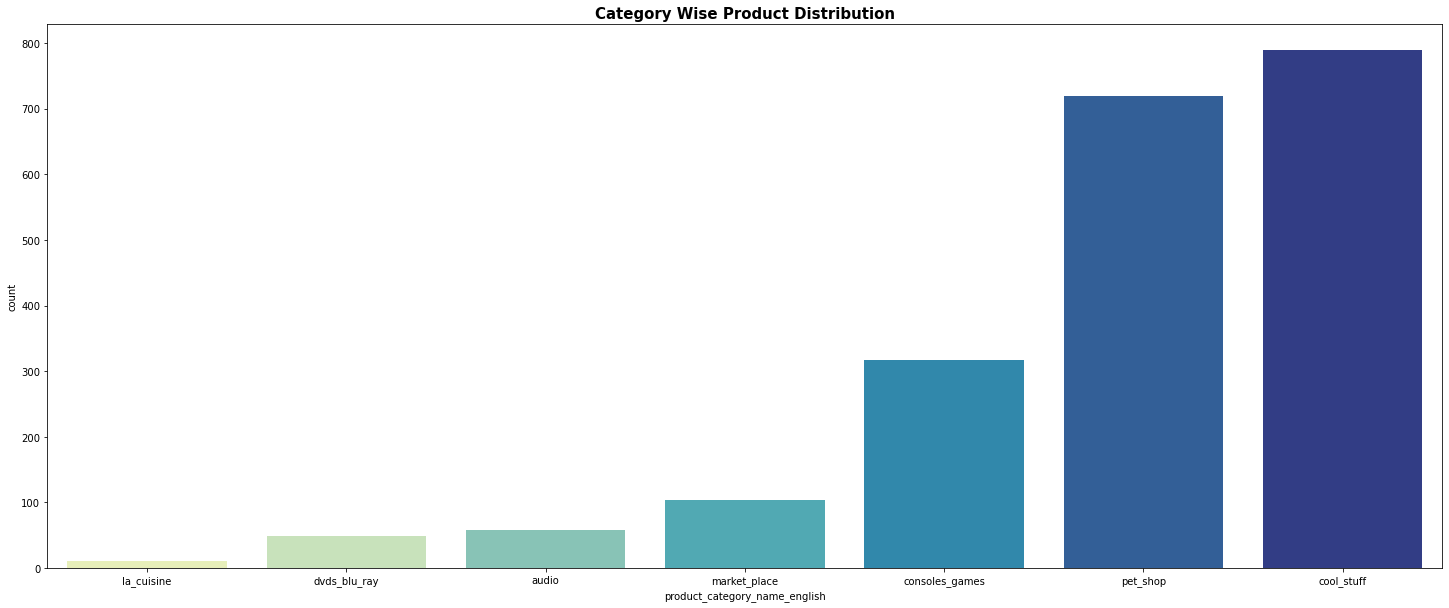

In [96]:
plt.figure(figsize=(25,10))
sns.countplot(x='product_category_name_english', data=df_products_copy, palette='YlGnBu',
             order=df_products_copy['product_category_name_english'].value_counts()[:10]\
             .sort_values().index).set_title("Category Wise Product Distribution", fontsize=15,
                                             weight='bold')

In [98]:
#Save the merged table
df_orders_item_products.to_csv("cleaned_Merged_df_products_copy.csv",
          header=True
         , index=False
         , chunksize=100000
         , compression='gzip'
         , encoding='utf-8')

**Insight**
1. The above chart shows very obvious different pattern on how casual and registered bikeshare rides differs based on hour in a day.
2. The registered bikeshare rides shows peak on 8.00 and 17.00. Given both these hours are time when people go to work and coming back from work, it's possible that registered bikeshare users use the bike to commute to work.
3. On the other hand, casual bikeshare rides shows higher frequency  during the day, then it starts to decrease after 17.00.

### Average Time for goods to be delivered in Brazil

In [ ]:
df_orders_copy = df_orders.copy()

In [ ]:
# engineering features
from datetime import datetime as dt
df_orders_copy['diff_app_pur'] = (pd.to_datetime(df_orders_copy.order_approved_at) - pd.to_datetime(df_orders_copy.order_purchase_timestamp)).dt.seconds
df_orders_copy['diff_car_app'] = (pd.to_datetime(df_orders_copy.order_delivered_carrier_date) - pd.to_datetime(df_orders_copy.order_approved_at)).dt.days
df_orders_copy['diff_del_car'] = (pd.to_datetime(df_orders_copy.order_delivered_customer_date) - pd.to_datetime(df_orders_copy.order_delivered_carrier_date)).dt.days
df_orders_copy['diff_est_act'] = (pd.to_datetime(df_orders_copy.order_estimated_delivery_date) - pd.to_datetime(df_orders_copy.order_delivered_customer_date)).dt.days

In [ ]:
print(str.format('Average time taken for the order to get approved: {:.2f} seconds', df_orders_copy.diff_app_pur.mean()))
print(str.format('Average time taken for the order to be passed to the logistic partner: {:.0f} days', df_orders_copy.diff_car_app.mean()))
print(str.format('Average time taken for the order to be delivered by the logistic partner: {:.0f} days', df_orders_copy.diff_del_car.mean()))
print(str.format('Average time taken between estimated delivery date and actual delivery date: {:.0f} days', df_orders_copy.diff_est_act.mean()))

**Insight**
1. The above chart shows very obvious different pattern on how casual and registered bikeshare rides differs based on hour in a day.
2. The registered bikeshare rides shows peak on 8.00 and 17.00. Given both these hours are time when people go to work and coming back from work, it's possible that registered bikeshare users use the bike to commute to work.
3. On the other hand, casual bikeshare rides shows higher frequency  during the day, then it starts to decrease after 17.00.

## Conclusion
---
1. Introduce Weekend Pass. The Weekend Pass is targeted to casual riders who mostly rent a bike during weekend. The Weekend Pass will have lower price point than the Annual Pass, but can only be used during Friday, Saturday, and Sunday.

2. Create a reward point campaign; give user reward points which accumulated by riding duration. Since casual riders ride duration is higher than current member riders, they will benefit more from this campaign. Offer them membership discount when they reach certain points to convert them into Cyclistic's member.

3. Perform strategic campaign during summer. Given the number of riders are at its annual peak in summer, we can do strategic campaign and advertising to reach more audience. 